In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorWithPadding, set_seed, get_scheduler
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm


set_seed(
    42, 
    # deterministic=True # this refuses to work:
    )

### Model, Tokenizer, hyperparams prep
# model_id = "HuggingFaceTB/SmolLM2-135M-Instruct"
model_id = "allenai/OLMo-2-1124-7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    dtype="bfloat16",
    device_map="cuda:0",
    )
max_length = 2048
batch_size = 1
num_epochs = 1

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
### Dataset prep
# dataset_id = "Neelectric/OpenR1-Math-220k_extended_Llama3_4096toks"
dataset_id = "Neelectric/OpenR1-Math-220k_CN-K12_OLMo-2_4096toks"

dataset_raw = load_dataset(dataset_id)["train"]
dataset_subset = dataset_raw.select(range(0,100))

In [3]:
### Dataset tokenization
system_prompt_content = "You are a helpful AI Assistant that provides well-reasoned and detailed responses. You first think about the reasoning process as an internal monologue and then provide the user with the answer. Respond in the following format: <think>\n...\n</think>\n<answer>\n...\n</answer>"
system_prompt = [{
    "content": system_prompt_content,
    "role": "system"
    }]

def tokenize_function(example):
    messages =  system_prompt + example["messages"]
    templated = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
    tokenized = tokenizer(
        templated, 
        # return_tensors="pt", #it appears this causes addition of redundant batch dimension, e.g.
        # {'input_ids': torch.Size([8, 1, 2048]), 'attention_mask': torch.Size([8, 1, 2048])} instead of {'input_ids': torch.Size([8, 2048]), 'attention_mask': torch.Size([8, 2048])}
        
        # #old vals
        # truncation=True, 
        # padding='max_length',
        # max_length=max_length
        
        # new vals
        truncation=False, 
        padding=False,
        )
    labels = tokenized["input_ids"].copy()
    # we need to be careful to mask padding tokens!!!
    labels = [-100 if token_id == tokenizer.pad_token_id else token_id for token_id in labels]
    tokenized["labels"] = labels
    return tokenized


first_sample = dataset_subset[0]
tokenized = tokenize_function(first_sample)
tokenized_dataset = dataset_subset.map(tokenize_function, num_proc=16)
tokenized_dataset = tokenized_dataset.remove_columns(['problem', 'solution', 'answer', 'problem_type', 'question_type', 'source', 'uuid', 'is_reasoning_complete', 'generations', 'correctness_math_verify', 'correctness_llama', 'finish_reasons', 'correctness_count', 'messages'])
print(tokenized_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})


In [4]:
### Data Collator and Data Loader prep
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    tokenized_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
for batch in train_dataloader:
    break
# batched = {k: v.shape for k, v in batch.items()}
# print(batched)
# outputs = model(**batch.to(model.device))
# print(outputs)
batch["input_ids"]

tensor([[   1, 9690,  198,  ...,   77,    2,  198]])

In [5]:
tokenizer.decode(batch["input_ids"][0])

"<|im_start|>system\nYou are a helpful AI Assistant that provides well-reasoned and detailed responses. You first think about the reasoning process as an internal monologue and then provide the user with the answer. Respond in the following format: <think>\n...\n</think>\n<answer>\n...\n</answer><|im_end|>\n<|im_start|>user\nThe equation of the circle passing through point A(1, -1) and B(-1, 1) with its center on the line $x+y-2=0$ is ( )\nA: $(x-3)^2+(y+1)^2=4$\nB: $(x-1)^2+(y-1)^2=4$\nC: $(x+3)^2+(y-1)^2=4$\nD: $(x+1)^2+(y+1)^2=4$<|im_end|>\n<|im_start|>assistant\n<think>\nOkay, let's try to figure out this problem. So, we need to find the equation of a circle that passes through points A(1, -1) and B(-1, 1), and the center of the circle lies on the line x + y - 2 = 0. The options are given, so maybe I can use some geometry concepts to find the right answer.\n\nFirst, I remember that the general equation of a circle is (x - h)^2 + (y - k)^2 = r^2, where (h, k) is the center and r is 

# Let's compute the Fisher Diagonal

In [6]:
batch["input_ids"].shape

torch.Size([1, 2233])

In [7]:
print(len(train_dataloader))

1000


In [8]:
num_training_steps = num_epochs * len(train_dataloader)
print(f"Training for {num_training_steps} steps")
device = model.device
progress_bar = tqdm(range(num_training_steps))

from copy import deepcopy
import torch


fisher = {}
params = {name: param for name, param in model.named_parameters() if param.requires_grad}
for name, param in deepcopy(params).items():
    param.data.zero_()
    fisher[name] = param.data

### fisher estimation loop
model.eval()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        # print(outputs)
        progress_bar.update(1)
        tqdm.write(f"loss is {loss}")
        for name, param in model.named_parameters():
            fisher[name].data += param.grad.data ** 2 / len(train_dataloader)
    break

Training for 1000 steps


  0%|          | 0/1000 [00:00<?, ?it/s]

loss is 1.5290237665176392
loss is 1.5753107070922852
loss is 1.393678069114685
loss is 1.2019230127334595
loss is 1.3078184127807617
loss is 1.3803123235702515
loss is 1.2848196029663086
loss is 1.1462823152542114
loss is 1.3458964824676514
loss is 1.336927890777588
loss is 1.3079090118408203
loss is 1.4129284620285034
loss is 1.3927953243255615
loss is 1.3822060823440552
loss is 1.2268481254577637
loss is 1.2393343448638916
loss is 1.1325650215148926
loss is 1.1715947389602661
loss is 1.3667842149734497
loss is 1.1978846788406372
loss is 1.1904207468032837
loss is 1.4920419454574585
loss is 1.0265145301818848
loss is 0.9277270436286926
loss is 1.1992254257202148
loss is 1.2288050651550293
loss is 1.5816123485565186
loss is 1.4940710067749023
loss is 1.3445621728897095
loss is 1.7018842697143555
loss is 1.4707173109054565
loss is 1.5987757444381714
loss is 1.0039972066879272
loss is 1.2540448904037476
loss is 1.1339033842086792
loss is 1.2889435291290283
loss is 1.5239644050598145
los

In [9]:
params['model.embed_tokens.weight'][0]

tensor([-1.0596e-01,  3.4180e-02,  4.7607e-02, -2.3926e-02, -6.7383e-02,
        -4.6387e-02,  1.9775e-02, -1.2061e-01,  1.0547e-01, -2.2266e-01,
         2.9907e-03, -8.5938e-02,  2.1875e-01, -3.2227e-01, -3.0859e-01,
         1.9653e-02, -7.7209e-03,  8.4961e-02, -9.2773e-02, -4.6631e-02,
         4.0039e-02,  1.9922e-01, -6.0547e-02,  7.6172e-02, -1.4160e-02,
        -1.8799e-02, -7.5195e-02,  4.1992e-02,  1.0059e-01,  1.4551e-01,
         7.8613e-02, -1.9922e-01, -9.2773e-02, -1.5137e-01,  1.2390e-02,
         3.3951e-04,  5.6152e-02,  8.2520e-02,  6.0303e-02, -8.7402e-02,
         6.6895e-02,  1.1475e-01,  2.6733e-02,  1.7212e-02,  8.8379e-02,
        -5.3467e-02,  1.3672e-01, -1.8848e-01,  6.4941e-02, -1.4941e-01,
         1.8164e-01, -1.2158e-01,  9.0820e-02, -9.1309e-02,  2.9785e-02,
         1.1719e-01,  3.3203e-02,  1.7676e-01, -8.3984e-02,  2.2461e-02,
        -2.3560e-02,  2.3926e-02,  1.1621e-01, -9.1171e-04, -9.6191e-02,
        -1.1963e-01,  6.9336e-02,  5.9204e-03, -1.4

In [10]:
fisher['model.embed_tokens.weight'][0]

tensor([2.9802e-08, 2.1653e-08, 9.3132e-10, 2.9802e-08, 7.4506e-09, 3.7253e-09,
        7.4506e-09, 1.4901e-08, 3.7253e-09, 5.9605e-08, 7.4506e-09, 7.4506e-09,
        5.9605e-08, 1.9558e-08, 1.1921e-07, 1.8626e-09, 1.8626e-09, 1.9073e-06,
        1.4901e-08, 7.4506e-09, 9.3132e-10, 7.4506e-09, 7.0722e-09, 1.4901e-08,
        2.3283e-10, 2.9802e-07, 7.4506e-09, 9.4064e-08, 3.7253e-09, 3.7253e-09,
        2.9802e-08, 2.3842e-07, 2.3865e-08, 3.7253e-09, 1.4901e-08, 1.8626e-09,
        5.9605e-08, 7.4506e-09, 1.8626e-09, 2.9802e-08, 7.4506e-09, 1.8859e-08,
        1.4901e-08, 6.9849e-10, 7.4506e-09, 1.1921e-07, 1.1921e-07, 9.3132e-10,
        2.9802e-08, 1.8626e-09, 1.8626e-09, 9.3132e-10, 4.6566e-10, 9.3132e-10,
        1.8626e-09, 1.8626e-09, 7.4506e-09, 2.9802e-08, 1.1700e-08, 4.7684e-07,
        7.4506e-09, 5.9605e-08, 1.6662e-09, 2.9802e-08, 5.9605e-08, 1.8626e-09,
        4.6566e-10, 1.1921e-07, 1.1316e-07, 1.8626e-09, 7.4506e-09, 3.7253e-09,
        2.9802e-08, 1.8626e-09, 7.4506e-

# let's try and plot this?

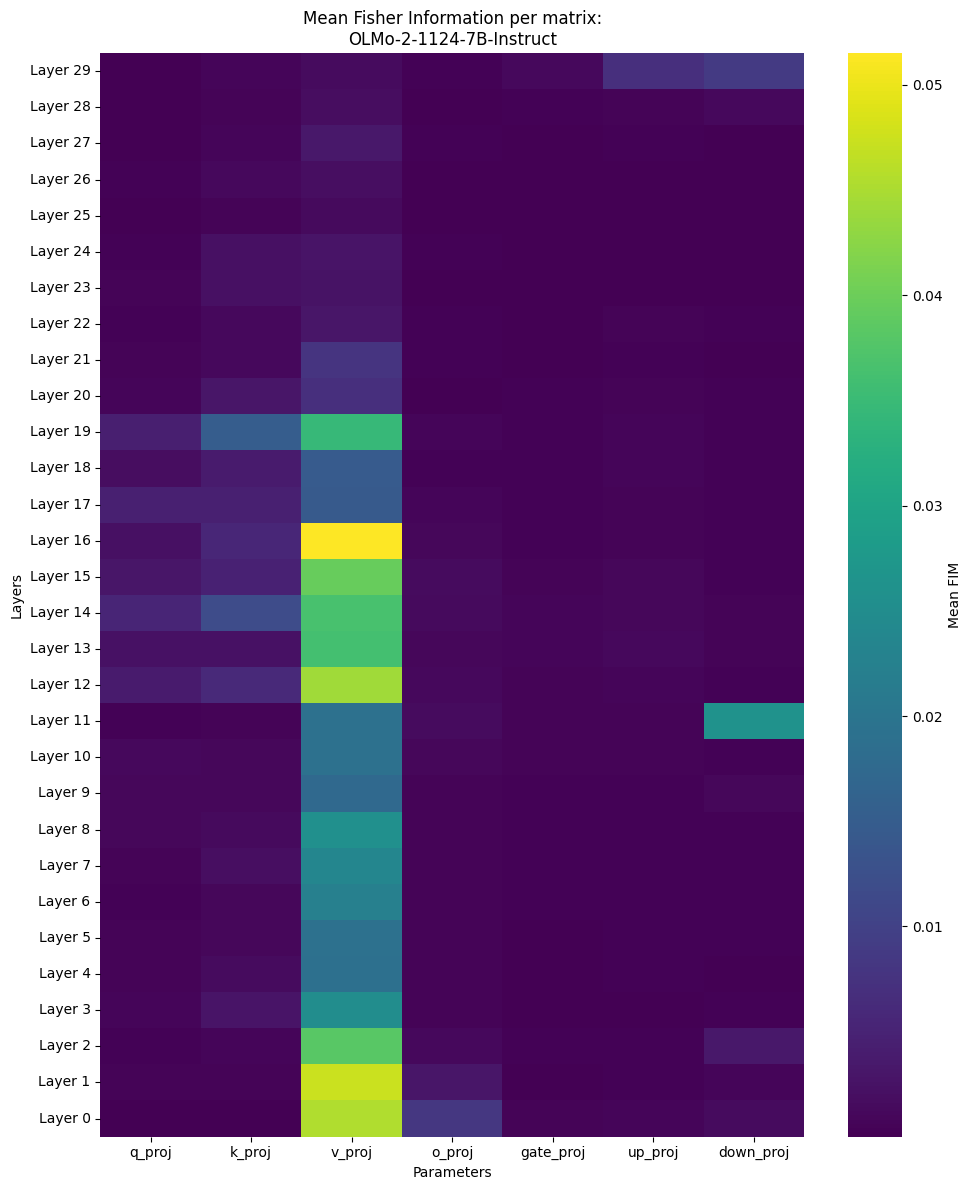

In [11]:


import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define parameter types in order (matching your plot)
param_types = ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']

# Adjust based on your model
num_layers = len(model.model.layers)

# Create matrix to store mean FIM values
fim_matrix = np.zeros((num_layers, len(param_types)))

# Populate the matrix
for name, fim_values in fisher.items():
    for i, ptype in enumerate(param_types):
        if ptype in name:
            # Extract layer number (assumes naming like model.layers.X....)
            parts = name.split('.')
            for j, part in enumerate(parts):
                if part == 'layers' and j + 1 < len(parts):
                    layer_num = int(parts[j + 1])
                    # Option 1: mean FIM (normalized by param count)
                    fim_matrix[layer_num, i] = fim_values.mean().item()
                    break
            break

# Create DataFrame
df = pd.DataFrame(fim_matrix, 
                  index=[f'Layer {i}' for i in range(num_layers)],
                  columns=param_types)

# Reverse so Layer 31 is at top
df = df.iloc[::-1]

# Plot
plt.figure(figsize=(10, 12))
sns.heatmap(df, cmap='viridis', cbar_kws={'label': 'Mean FIM'})
plt.xlabel('Parameters')
plt.ylabel('Layers')
plt.title('Mean Fisher Information per matrix:\nOLMo-2-1124-7B-Instruct')
plt.tight_layout()
plt.savefig('fim_heatmap.png', dpi=150)
plt.show()